## Bots in en.wikipedia.org over time

Based on the bot dataset at https://github.com/halfak/are-the-bots-really-fighting/datasets/

In [1]:
!pip install pandas seaborn mwapi
import pandas as pd
import seaborn as sns
import mwapi
import numpy as np
%matplotlib inline

## Load data and initalize mwapi

In [2]:
languages = ["en", "de", "es", "ja", "zh", "ar", "hu", "fr"]

sessions = {}
for language in languages:
    sessions[language] = mwapi.Session("https://" + language + ".wikipedia.org",
                                       user_agent="Research script by User:Staeiou")

In [3]:
with open("../../datasets/crosswiki_unified_bot_20170328.tsv") as f:
    bots = f.read()
    bot_list = bots.split("\n")
    
print(len(bot_list))

6523


## Function for querying API to get first edit

In [4]:
def get_first_edits(language):
    """
    With list of all bots, get the datetime of first edit for a language version.
    Bots with no edits have a datetime of np.nan
    
    Parameters:
        language, a subdomain of en.wikipedia.org
    Returns:
        first_edit_df, a dataframe containing {bot name, datetime of first edit}
    """
    first_edit_df = pd.DataFrame(columns=["bot", "first_edit"])

    for bot in bot_list:
        try:
            result = sessions[language].get(action='query', list='usercontribs', uclimit=1, ucdir='newer', ucuser=bot)
            timestamp = result['query']['usercontribs'][0]['timestamp']
        except:
            timestamp = np.nan

        if timestamp is not np.nan:
            bot_dict = {'bot':bot, 'first_edit' : timestamp}
            #print(bot_dict)
            first_edit_df = first_edit_df.append(bot_dict, ignore_index=True)
            #print(first_edit_df)

        #if len(first_edit_df) % 500 == 0:
            #print(len(first_edit_df), sep=" ")
    return first_edit_df

## Get first edit dataframes for each language

In [5]:
first_edit_df_dict = {}

for language in languages:
    print("-----")
    print(language)
    print("-----")
    first_edit_df_dict[language] = get_first_edits(language)

-----
en
-----
-----
de
-----
-----
es
-----
-----
ja
-----
-----
zh
-----
-----
ar
-----
-----
hu
-----
-----
fr
-----


## Export raw dataset to pickle

In [6]:
import pickle

In [7]:
with open("bot_first_edit_df_dict.pickle", "wb") as f:
    pickle.dump(first_edit_df_dict, f)

## Make a tidy dataframe

One dataframe, one row for each bot in each language

In [43]:
tidy_df = pd.DataFrame(columns=["bot","language","first_edit"])

for lang, lang_df in first_edit_df_dict.items():
    for index, row in lang_df.iterrows():        
        bot_dict = {"bot":row['bot'], "language":lang, "first_edit":row['first_edit']}
        tidy_df = tidy_df.append(bot_dict, ignore_index=True)


In [55]:
tidy_df['first_edit_dt'] = pd.to_datetime(tidy_df['first_edit'], format="%Y-%m-%dT%H:%M:%SZ")


In [56]:
tidy_df_i = tidy_df.set_index('first_edit_dt')

In [143]:
tidy_df_i.to_pickle("bot_first_edit_tidy_df.pickle")

In [144]:
!bzip2 -k bot_first_edit_tidy_df.pickle

## Group by number of new bots per langauge per month

In [145]:
gb = tidy_df_i.groupby([pd.TimeGrouper("1M"), 'language'])['bot']

In [146]:
monthly_lang = gb.count().unstack()
monthly_lang[0:10]

language,ar,de,en,es,fr,hu,ja,zh
first_edit_dt,,,,,,,,
2001-07-31,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2001-09-30,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2001-12-31,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2002-01-31,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2002-03-31,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2002-04-30,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2002-08-31,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2002-10-31,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2002-12-31,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN


## Plot number of new bots per month per language

In [151]:
sns.set(font_scale=2)

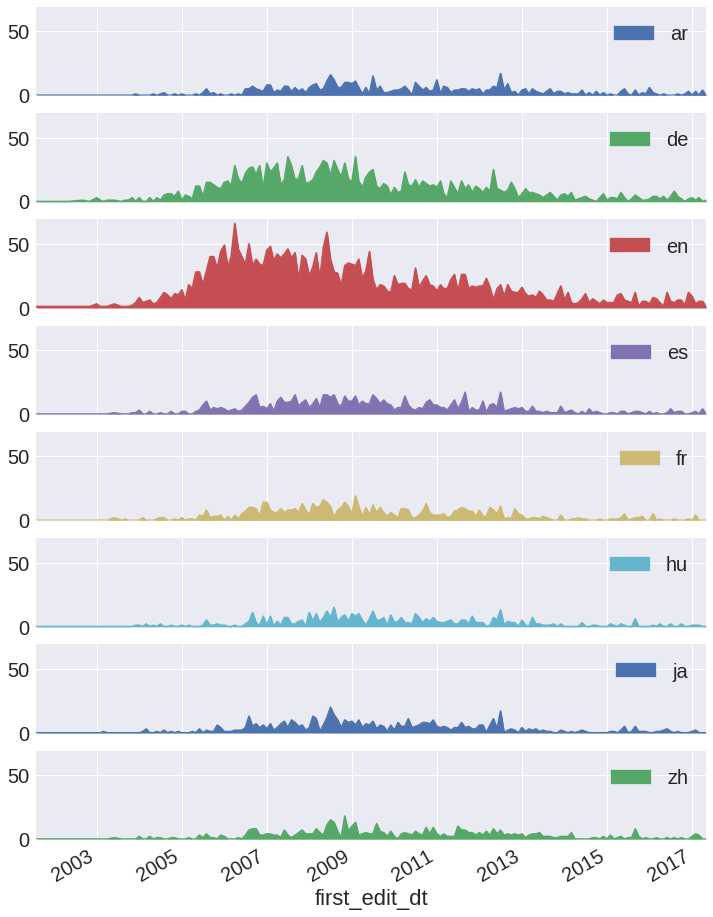

In [152]:
axes = monthly_lang.plot(kind="area", figsize=[12,17], subplots=True, sharey=True)

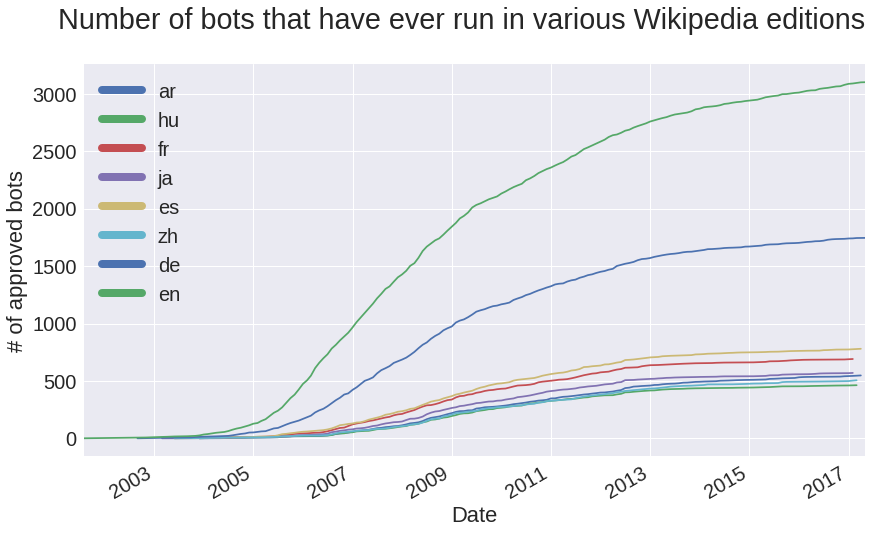

In [153]:
pal = sns.color_palette("husl", 7)

for lang, lang_df in first_edit_df_dict.items():
        
    ax = lang_df['bot'].groupby([pd.TimeGrouper("1M")]).count().cumsum().plot(figsize=[14,8], logy=False)

    ax.set_xlabel("Date")
    ax.set_ylabel("# of approved bots")
plt.suptitle("Number of bots that have ever run in various Wikipedia editions")
leg = plt.legend(first_edit_df_dict.keys())
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

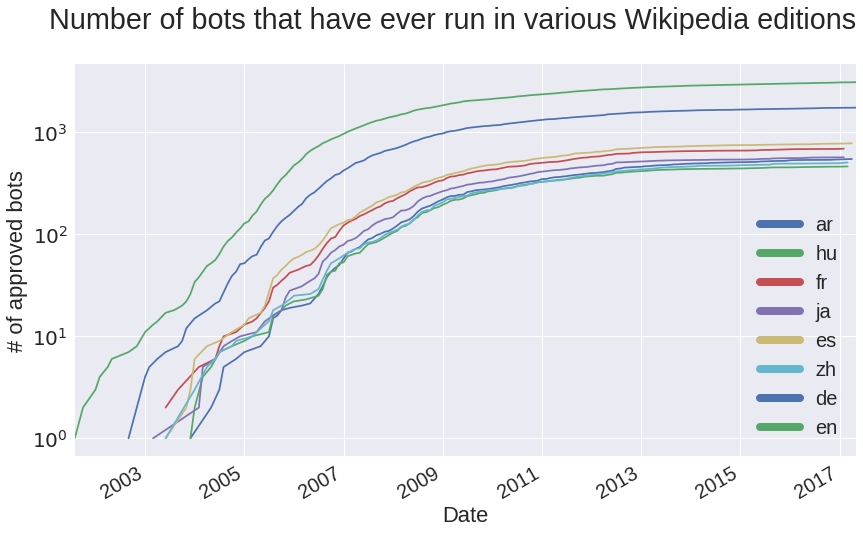

In [154]:
pal = sns.color_palette("husl", 7)

for lang, lang_df in first_edit_df_dict.items():
        
    ax = lang_df['bot'].groupby([pd.TimeGrouper("1M")]).count().cumsum().plot(figsize=[14,8], logy=True)

    ax.set_xlabel("Date")
    ax.set_ylabel("# of approved bots")
plt.suptitle("Number of bots that have ever run in various Wikipedia editions")
leg = plt.legend(first_edit_df_dict.keys())
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

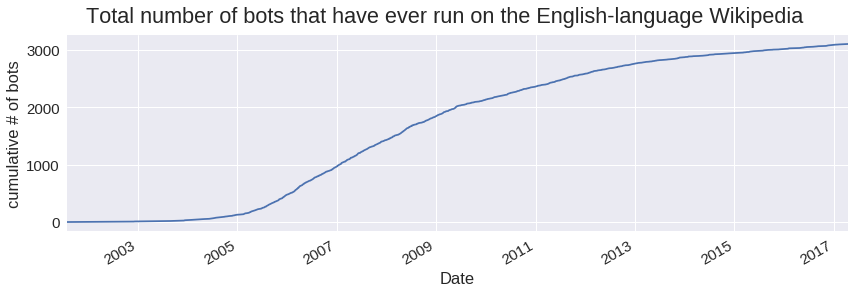

In [155]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

ax = first_edit_df_dict['en']['bot'].groupby([pd.TimeGrouper("1D")]).count().cumsum().plot(figsize=[14,4])
ax.set_xlabel("Date")
ax.set_ylabel("cumulative # of bots")
plt.suptitle("Total number of bots that have ever run on the English-language Wikipedia")